In [7]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D, Reshape

In [2]:
finalData = pd.read_csv("AAPL_processed.csv")
finalData.set_index('DateTime',inplace=True)  
cols = finalData.columns.tolist()
cols = cols[-1:] + cols[:-1]
finalData = finalData[cols]

In [3]:
# Rescale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(finalData.values)

# Function to convert series to supervised learning format
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Configure parameters
n_hours = 3
n_features = 1
n_obs = n_hours * n_features

# Transform into supervised format
reframed = series_to_supervised(scaled, n_hours, 1)
reframed = reframed.drop(reframed.columns[-1], axis=1)




In [11]:
# Split into train and test sets
values = reframed.values
n_train_hours = 170
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# Reshape input to 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))



In [14]:
# Define CNN-LSTM model
model = Sequential()

# Add CNN layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                 input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Flatten())  # Flatten the CNN output

# Reshape flattened output to 3D for LSTM (timesteps = 1, features = 64)
model.add(Reshape((1, 64)))  # Reshape to (samples, timesteps=1, features=64)

# Add LSTM layer
model.add(LSTM(5, activation='relu', return_sequences=False))

# Add Dense layer for output
model.add(Dense(1))

# Compile model
model.compile(optimizer='adam', loss='mae')

# Fit the model
history = model.fit(train_X, train_y, epochs=200, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)



Epoch 1/200
43/43 - 1s - loss: 0.3405 - val_loss: 0.5761 - 594ms/epoch - 14ms/step
Epoch 2/200
43/43 - 0s - loss: 0.1966 - val_loss: 0.2183 - 66ms/epoch - 2ms/step
Epoch 3/200
43/43 - 0s - loss: 0.0614 - val_loss: 0.1335 - 56ms/epoch - 1ms/step
Epoch 4/200
43/43 - 0s - loss: 0.0688 - val_loss: 0.1217 - 53ms/epoch - 1ms/step
Epoch 5/200
43/43 - 0s - loss: 0.0615 - val_loss: 0.1172 - 53ms/epoch - 1ms/step
Epoch 6/200
43/43 - 0s - loss: 0.0601 - val_loss: 0.1031 - 56ms/epoch - 1ms/step
Epoch 7/200
43/43 - 0s - loss: 0.0593 - val_loss: 0.0972 - 61ms/epoch - 1ms/step
Epoch 8/200
43/43 - 0s - loss: 0.0563 - val_loss: 0.0864 - 63ms/epoch - 1ms/step
Epoch 9/200
43/43 - 0s - loss: 0.0538 - val_loss: 0.0808 - 65ms/epoch - 2ms/step
Epoch 10/200
43/43 - 0s - loss: 0.0517 - val_loss: 0.0750 - 69ms/epoch - 2ms/step
Epoch 11/200
43/43 - 0s - loss: 0.0477 - val_loss: 0.1123 - 65ms/epoch - 2ms/step
Epoch 12/200
43/43 - 0s - loss: 0.0571 - val_loss: 0.0774 - 58ms/epoch - 1ms/step
Epoch 13/200
43/43 - 0s

In [15]:
# Print model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 1, 64)             256       
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 reshape_3 (Reshape)         (None, 1, 64)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 1400      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1662 (6.49 KB)
Trainable params: 1662 (6.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


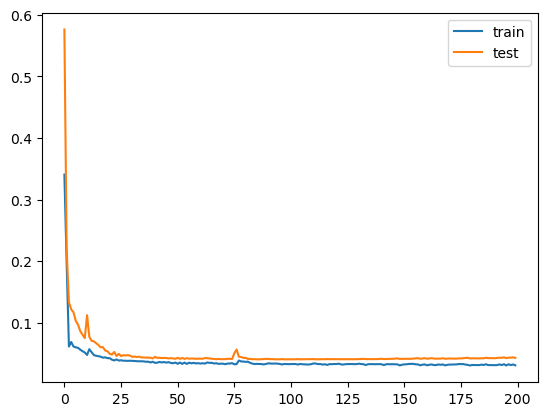

In [16]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [17]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

5/5 [==============================] - 0s 850us/step
Test RMSE: 5.726


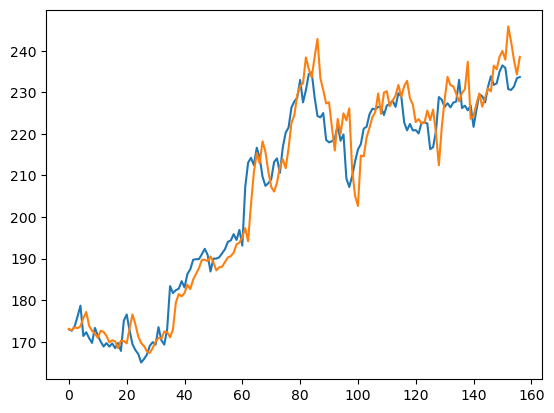

In [18]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()